In [1]:
# =============================================================================
# notebook_analysis.py — Análise exploratória e métricas para parquets históricos
# =============================================================================
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# configs visuais (matplotlib)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['grid.alpha'] = 0.25

HIST_DIR = Path("data/historical")
assert HIST_DIR.exists(), f"{HIST_DIR} não encontrado. Ajuste o caminho."

In [3]:
# ---------------------------
# 1) Função: carregar todos os parquets em um DataFrame longo
# ---------------------------
def load_all_parquets_to_long(hist_dir=HIST_DIR, tickers=None, date_col_candidates=('date','Date','index')):
    files = []
    if tickers:
        for t in tickers:
            p = hist_dir / f"{t}.parquet"
            if p.exists(): files.append(p)
    else:
        files = list(hist_dir.glob("*.parquet"))
    if not files:
        raise RuntimeError("Nenhum parquet encontrado em " + str(hist_dir))
    rows = []
    meta = []
    for f in tqdm(files, desc="Lendo parquets"):
        try:
            df = pd.read_parquet(f)
            # normalizar nome do ticker: inferir do arquivo se não existe
            ticker = f.stem
            df = df.copy()
            # garantir coluna date
            if 'date' not in df.columns and 'Date' in df.columns:
                df = df.rename(columns={'Date':'date'})
            if 'date' not in df.columns:
                # tentar inferir índice datetime
                if df.index.name and 'date' in df.index.name.lower():
                    df = df.reset_index()
                elif isinstance(df.index, pd.DatetimeIndex):
                    df = df.reset_index().rename(columns={df.index.name or 0:'date'})
                else:
                    # fallback: criar a coluna se não houver
                    raise RuntimeError(f"{f.name} não tem coluna 'date' detectada")
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            # garantir colunas básicas: Open, High, Low, Close, Adj Close, Volume
            expected = ['Open','High','Low','Close','Adj Close','Volume']
            # harmonizar nomes comuns (alguns parquets podem ter 'Adj Close' ou 'Adj_Close' ou 'Adj_Close')
            df_cols = {c: c for c in df.columns}
            # inserir ticker
            df['ticker'] = ticker
            rows.append(df)
            meta.append({'file':f.name, 'ticker':ticker, 'rows':len(df), 'start':df['date'].min(), 'end':df['date'].max()})
        except Exception as e:
            print("Falha lendo", f, e)
    big = pd.concat(rows, ignore_index=True, sort=False)
    # ordenar e remover duplicados exatos de (ticker,date)
    big = big.sort_values(['ticker','date']).drop_duplicates(subset=['ticker','date'], keep='last').reset_index(drop=True)
    return big, pd.DataFrame(meta)


In [4]:
# ---------------------------
# 2) Carregar dados (executar)
# ---------------------------
big, meta = load_all_parquets_to_long()
display(meta.head(20))
print("Total rows combined:", len(big))
print("Tickers combinados:", big['ticker'].nunique())

Lendo parquets: 100%|██████████| 98/98 [00:02<00:00, 38.96it/s]


,file,ticker,rows,start,end
0,ABEV3.SA.parquet,ABEV3.SA,6476,2000-01-03,2025-10-15
1,all_histories.parquet,all_histories,1256344,2000-01-03,2025-10-15
2,ALOS3.SA.parquet,ALOS3.SA,6476,2000-01-03,2025-10-15
3,ANIM3.SA.parquet,ANIM3.SA,6476,2000-01-03,2025-10-15
4,ASAI3.SA.parquet,ASAI3.SA,6476,2000-01-03,2025-10-15
5,AURE3.SA.parquet,AURE3.SA,6476,2000-01-03,2025-10-15
6,AZZA3.SA.parquet,AZZA3.SA,6476,2000-01-03,2025-10-15
7,BBAS3.SA.parquet,BBAS3.SA,6476,2000-01-03,2025-10-15
8,BBDC3.SA.parquet,BBDC3.SA,6476,2000-01-03,2025-10-15
9,BBDC4.SA.parquet,BBDC4.SA,6476,2000-01-03,2025-10-15


Total rows combined: 634648
Tickers combinados: 98


In [5]:
# ---------------------------
# 3) Checagem de qualidade básica
# ---------------------------
def quality_report(big_df):
    report = {}
    # por ticker: contagem, primeira, última data, gaps
    grp = big_df.groupby('ticker')
    r = grp['date'].agg(['min','max','count']).rename(columns={'min':'first','max':'last','count':'nrows'}).reset_index()
    r['period_days'] = (r['last'] - r['first']).dt.days
    # checar missing values por coluna (global)
    missing_global = big_df.isna().sum().sort_values(ascending=False)
    # checar número de datas únicas (padrão B3 ~dias úteis)
    date_counts = big_df.groupby('date')['ticker'].nunique().sort_values(ascending=False).head(10)
    report['by_ticker'] = r
    report['missing_global'] = missing_global
    report['top_dates_by_coverage'] = date_counts
    return report

qrep = quality_report(big)
display(qrep['by_ticker'].sort_values('nrows', ascending=False).head(20))
print("Missing (global):")
print(qrep['missing_global'])


,ticker,first,last,nrows,period_days
0,ABEV3.SA,2000-01-03,2025-10-15,6476,9417
1,ALOS3.SA,2000-01-03,2025-10-15,6476,9417
2,ANIM3.SA,2000-01-03,2025-10-15,6476,9417
3,ASAI3.SA,2000-01-03,2025-10-15,6476,9417
4,AURE3.SA,2000-01-03,2025-10-15,6476,9417
5,AZZA3.SA,2000-01-03,2025-10-15,6476,9417
6,BBAS3.SA,2000-01-03,2025-10-15,6476,9417
7,BBDC3.SA,2000-01-03,2025-10-15,6476,9417
8,BBDC4.SA,2000-01-03,2025-10-15,6476,9417
9,BBSE3.SA,2000-01-03,2025-10-15,6476,9417


Missing (global):
Open            232765
High            232765
Volume          232765
Low             232765
Close           232765
Adj Close       232765
Stock Splits    232765
Dividends       232765
date                 0
ticker               0
dtype: int64


In [6]:
# ---------------------------
# 4) Harmonização e preenchimento de colunas essenciais
# ---------------------------
def harmonize_columns(df):
    df = df.copy()
    # renomear variações
    colmap = {}
    for c in df.columns:
        low = c.lower().replace(" ", "").replace("_","")
        if low in ('adjclose','adj_close','adjustedclose'): colmap[c] = 'Adj Close'
        if low == 'close': colmap[c] = 'Close'
        if low == 'open': colmap[c] = 'Open'
        if low == 'high': colmap[c] = 'High'
        if low == 'low': colmap[c] = 'Low'
        if low in ('volume','vol'): colmap[c] = 'Volume'
        if low in ('dividends','dividend'): colmap[c] = 'Dividends'
        if low in ('stocksplits','stock_splits','splits'): colmap[c] = 'Stock Splits'
    df = df.rename(columns=colmap)
    # garantir colunas existam; se não, criar com NaN
    for c in ['Open','High','Low','Close','Adj Close','Volume','Dividends','Stock Splits']:
        if c not in df.columns:
            df[c] = np.nan
    return df

big = harmonize_columns(big)

In [7]:
# ---------------------------
# 5) Calcular retornos diários por ticker
# ---------------------------
def compute_returns(df):
    df = df.copy()
    # ordenar
    df = df.sort_values(['ticker','date']).reset_index(drop=True)
    # group by ticker and compute pct_change on 'Adj Close' preferencialmente
    price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    df['price_used'] = df[price_col]
    df['ret_daily'] = df.groupby('ticker')['price_used'].pct_change()
    # log returns
    df['ret_log'] = np.log1p(df['ret_daily'])
    # forward returns (useful for target creation): next 1M, 3M, 6M, 12M (approx business days)
    df['ret_1d_forward'] = df.groupby('ticker')['price_used'].pct_change(periods=-1) * -1  # simpler to compute later if needed
    return df

big = compute_returns(big)

C:\Users\kaike\AppData\Local\Temp\ipykernel_17656\2741963878.py:11: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ret_daily'] = df.groupby('ticker')['price_used'].pct_change()
C:\Users\kaike\AppData\Local\Temp\ipykernel_17656\2741963878.py:15: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ret_1d_forward'] = df.groupby('ticker')['price_used'].pct_change(periods=-1) * -1  # simpler to compute later if needed


In [8]:
# ---------------------------
# 6) Estatísticas descritivas por ticker
# ---------------------------
def stats_per_ticker(df, trading_days_per_year=252):
    out = []
    for t, g in df.groupby('ticker'):
        g = g.dropna(subset=['price_used']).sort_values('date')
        if g.shape[0] < 2:
            continue
        daily_rets = g['ret_daily'].dropna()
        mean_daily = daily_rets.mean()
        vol_daily = daily_rets.std()
        # anualizar
        ann_return = (1 + mean_daily) ** trading_days_per_year - 1
        ann_vol = vol_daily * np.sqrt(trading_days_per_year)
        # CAGR (usando price series)
        try:
            start_p = g['price_used'].iloc[0]
            end_p = g['price_used'].iloc[-1]
            days = (g['date'].iloc[-1] - g['date'].iloc[0]).days
            years = days / 365.25 if days>0 else np.nan
            cagr = (end_p / start_p) ** (1/years) - 1 if years and years>0 else np.nan
        except Exception:
            cagr = np.nan
        sharpe = ann_return / ann_vol if ann_vol>0 else np.nan
        maxdd = calculate_max_drawdown(g['price_used'])
        out.append({'ticker': t, 'n_obs': len(g), 'first': g['date'].iloc[0], 'last': g['date'].iloc[-1],
                    'cagr': cagr, 'ann_return': ann_return, 'ann_vol': ann_vol, 'sharpe': sharpe, 'max_drawdown': maxdd})
    return pd.DataFrame(out).sort_values('cagr', ascending=False)

def calculate_max_drawdown(price_series):
    # price_series: pd.Series indexed by sequential time (not necessarily datetime index)
    p = price_series.fillna(method='ffill').dropna()
    if p.empty: return np.nan
    running_max = p.cummax()
    dd = (p / running_max) - 1
    return dd.min()  # negativo (ex: -0.45)

stats_df = stats_per_ticker(big)
display(stats_df.head(30))


C:\Users\kaike\AppData\Local\Temp\ipykernel_17656\2775273710.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  p = price_series.fillna(method='ffill').dropna()
C:\Users\kaike\AppData\Local\Temp\ipykernel_17656\2775273710.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  p = price_series.fillna(method='ffill').dropna()
C:\Users\kaike\AppData\Local\Temp\ipykernel_17656\2775273710.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  p = price_series.fillna(method='ffill').dropna()
C:\Users\kaike\AppData\Local\Temp\ipykernel_17656\2775273710.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  p = price_series.fillna(method='ffill').d

,ticker,n_obs,first,last,cagr,ann_return,ann_vol,sharpe,max_drawdown
69,RADL3.SA,6473,2000-01-06,2025-10-15,0.383535,0.614102,0.841865,0.729455,-0.623754
25,CURY3.SA,1263,2020-09-21,2025-10-15,0.359870,0.473013,0.391757,1.207415,-0.473148
11,BPAC11.SA,2153,2017-02-24,2025-10-15,0.356613,0.496874,0.435733,1.140317,-0.680142
49,ISAE4.SA,6427,2000-01-03,2025-10-15,0.315359,0.422326,0.392755,1.075291,-0.662011
19,CPFE3.SA,6476,2000-01-03,2025-10-15,0.255463,1.516341,3.603304,0.420820,-0.628743
95,WEGE3.SA,6476,2000-01-03,2025-10-15,0.251421,0.321238,0.331520,0.968987,-0.641985
57,MOTV3.SA,124,2025-04-23,2025-10-15,0.226874,0.256068,0.234762,1.090755,-0.120172
75,RENT3.SA,5077,2005-05-23,2025-10-15,0.209317,0.326709,0.425718,0.767430,-0.767709
28,CYRE3.SA,6476,2000-01-03,2025-10-15,0.190304,0.338416,0.491018,0.689213,-0.809836
87,TOTS3.SA,4875,2006-03-09,2025-10-15,0.182026,0.265656,0.363698,0.730429,-0.497133


C:\Users\kaike\AppData\Local\Temp\ipykernel_17656\3503911694.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_groups = pivot.resample('M').last().index


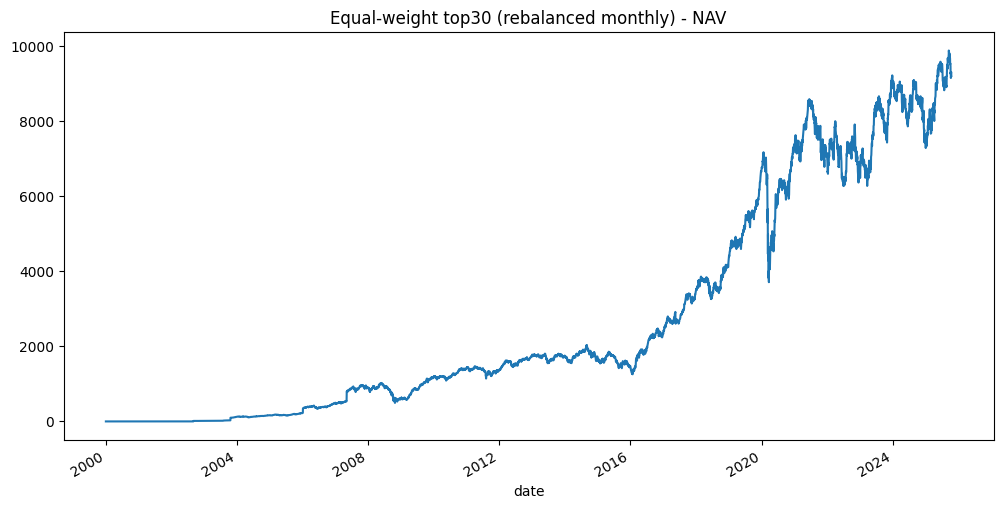

In [9]:
# ---------------------------
# 7) Curvas de capital (portfolio equal-weighted example)
# ---------------------------
def build_equal_weight_portfolio(df, tickers_list=None, start_date=None, rebalance='M'):
    """
    Constrói série de capital de um portfolio equal-weighted rebalanced mensalmente (ou 'M' para mês).
    df deve ter columns ['ticker','date','price_used'] com retornos já calculados.
    """
    df = df.copy()
    df = df.dropna(subset=['price_used'])
    if start_date:
        df = df[df['date']>=pd.to_datetime(start_date)]
    # pivot price series: index date, columns ticker
    pivot = df.pivot_table(index='date', columns='ticker', values='price_used')
    pivot = pivot.sort_index().ffill().dropna(how='all')
    # compute returns daily
    rets = pivot.pct_change().fillna(0)
    # monthly rebalance: create monthly periods
    if rebalance == 'M':
        # get month start labels
        month_groups = pivot.resample('M').last().index
        # simple approach: on each month-start allocate equal weights across available tickers
        weights = {}
        for dt in month_groups:
            # available at month end
            avail = pivot.loc[:dt].iloc[-1].dropna().index.tolist()
            w = pd.Series(1/len(avail), index=avail) if avail else pd.Series()
            weights[dt] = w
        # generate daily weight series by forward filling
        weight_df = pd.DataFrame(index=pivot.index, columns=pivot.columns, data=0.0)
        last_w = None
        for d in weight_df.index:
            # find last month end <= d
            key = max([k for k in weights.keys() if k<=d], default=None)
            if key is not None:
                w = weights[key]
                for col in weight_df.columns:
                    weight_df.at[d,col] = w.get(col, 0.0)
        # compute portfolio daily returns
        port_daily = (rets * weight_df).sum(axis=1)
        port_nav = (1 + port_daily).cumprod()
        return port_nav
    else:
        raise NotImplementedError("Only 'M' rebalance implemented in this util.")

# exemplo: top 30 tickers by cagr
top_tickers = stats_df.head(30)['ticker'].tolist()
port_nav = build_equal_weight_portfolio(big, tickers_list=top_tickers, start_date=None, rebalance='M')
port_nav.plot(title="Equal-weight top30 (rebalanced monthly) - NAV");



C:\Users\kaike\AppData\Local\Temp\ipykernel_17656\460362650.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = pivot.resample('M').last()


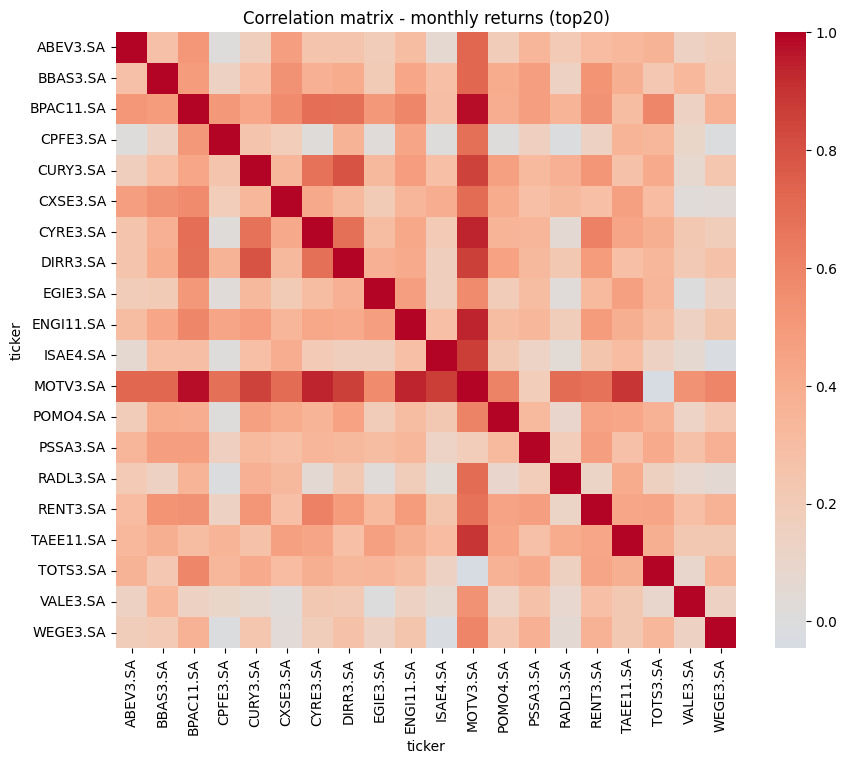

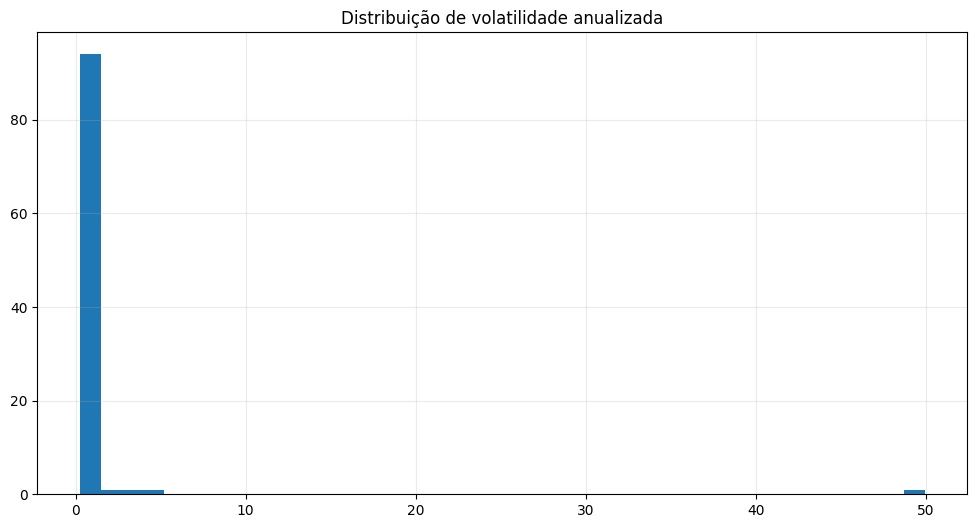

,ticker,n_obs,first,last,cagr,ann_return,ann_vol,sharpe,max_drawdown
69,RADL3.SA,6473,2000-01-06,2025-10-15,0.383535,0.614102,0.841865,0.729455,-0.623754
25,CURY3.SA,1263,2020-09-21,2025-10-15,0.359870,0.473013,0.391757,1.207415,-0.473148
11,BPAC11.SA,2153,2017-02-24,2025-10-15,0.356613,0.496874,0.435733,1.140317,-0.680142
49,ISAE4.SA,6427,2000-01-03,2025-10-15,0.315359,0.422326,0.392755,1.075291,-0.662011
19,CPFE3.SA,6476,2000-01-03,2025-10-15,0.255463,1.516341,3.603304,0.420820,-0.628743
95,WEGE3.SA,6476,2000-01-03,2025-10-15,0.251421,0.321238,0.331520,0.968987,-0.641985
57,MOTV3.SA,124,2025-04-23,2025-10-15,0.226874,0.256068,0.234762,1.090755,-0.120172
75,RENT3.SA,5077,2005-05-23,2025-10-15,0.209317,0.326709,0.425718,0.767430,-0.767709
28,CYRE3.SA,6476,2000-01-03,2025-10-15,0.190304,0.338416,0.491018,0.689213,-0.809836
87,TOTS3.SA,4875,2006-03-09,2025-10-15,0.182026,0.265656,0.363698,0.730429,-0.497133


Saved stats_per_ticker_summary.csv


In [10]:
# ---------------------------
# 8) Heatmap de correlação (retornos mensais)
# ---------------------------
def monthly_rets_pivot(df, tickers_select=None):
    df = df.copy()
    df = df.dropna(subset=['price_used'])
    if tickers_select:
        df = df[df['ticker'].isin(tickers_select)]
    pivot = df.pivot_table(index='date', columns='ticker', values='price_used').sort_index()
    # resample to month end and compute pct_change
    monthly_close = pivot.resample('M').last()
    monthly_rets = monthly_close.pct_change().dropna(how='all')
    return monthly_rets

monthly = monthly_rets_pivot(big, tickers_select=top_tickers[:20])
corr = monthly.corr()
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation matrix - monthly returns (top20)")
plt.show()

# ---------------------------
# 9) Visualizações e inspeções rápidas
# ---------------------------
# - Histogram of annualized vol
plt.figure()
stats_df['ann_vol'].dropna().hist(bins=40)
plt.title("Distribuição de volatilidade anualizada")
plt.show()

# - Top 10 by CAGR
display(stats_df.sort_values('cagr', ascending=False).head(10))

# - Save stats to csv
stats_df.to_csv("stats_per_ticker_summary.csv", index=False)
print("Saved stats_per_ticker_summary.csv")

In [11]:
import pandas as pd

df = pd.read_csv("stats_per_ticker_summary.csv")
df.head()


,ticker,n_obs,first,last,cagr,ann_return,ann_vol,sharpe,max_drawdown
0,RADL3.SA,6473,2000-01-06,2025-10-15,0.383535,0.614102,0.841865,0.729455,-0.623754
1,CURY3.SA,1263,2020-09-21,2025-10-15,0.359870,0.473013,0.391757,1.207415,-0.473148
2,BPAC11.SA,2153,2017-02-24,2025-10-15,0.356613,0.496874,0.435733,1.140317,-0.680142
3,ISAE4.SA,6427,2000-01-03,2025-10-15,0.315359,0.422326,0.392755,1.075291,-0.662011
4,CPFE3.SA,6476,2000-01-03,2025-10-15,0.255463,1.516341,3.603304,0.420820,-0.628743


In [12]:
df.describe()


,n_obs,cagr,ann_return,ann_vol,sharpe,max_drawdown
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,4100.846939,0.054770,2030.713099,1.023792,41.071889,-0.745432
std,2057.607405,0.137446,20100.965773,5.020305,402.379602,0.181893
min,124.000000,-0.392754,-0.317489,0.234762,-0.730836,-1.000000
25%,1967.500000,-0.004473,0.126922,0.369901,0.301827,-0.889538
50%,4424.500000,0.068693,0.189304,0.418229,0.424327,-0.766462
75%,6474.750000,0.142288,0.240229,0.501000,0.603420,-0.626257
max,6476.000000,0.383535,198989.617806,49.949962,3983.779176,-0.120172


In [13]:
# Top 10 pelo índice de Sharpe
df.nlargest(10, "sharpe")[["ticker", "sharpe", "ann_return", "ann_vol", "max_drawdown"]]

# Top 10 pelo CAGR
df.nlargest(10, "cagr")[["ticker", "cagr", "ann_return", "ann_vol"]]


,ticker,cagr,ann_return,ann_vol
0,RADL3.SA,0.383535,0.614102,0.841865
1,CURY3.SA,0.359870,0.473013,0.391757
2,BPAC11.SA,0.356613,0.496874,0.435733
3,ISAE4.SA,0.315359,0.422326,0.392755
4,CPFE3.SA,0.255463,1.516341,3.603304
5,WEGE3.SA,0.251421,0.321238,0.331520
6,MOTV3.SA,0.226874,0.256068,0.234762
7,RENT3.SA,0.209317,0.326709,0.425718
8,CYRE3.SA,0.190304,0.338416,0.491018
9,TOTS3.SA,0.182026,0.265656,0.363698


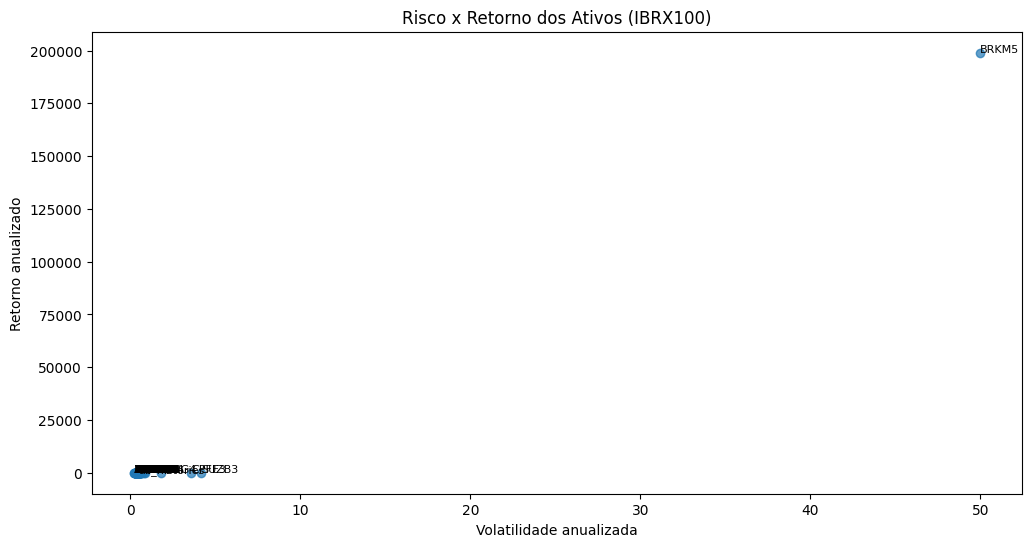

In [14]:
import matplotlib.pyplot as plt

plt.scatter(df["ann_vol"], df["ann_return"], alpha=0.7)
for _, row in df.iterrows():
    plt.text(row["ann_vol"], row["ann_return"], row["ticker"].replace(".SA", ""), fontsize=8)
plt.xlabel("Volatilidade anualizada")
plt.ylabel("Retorno anualizado")
plt.title("Risco x Retorno dos Ativos (IBRX100)")
plt.show()


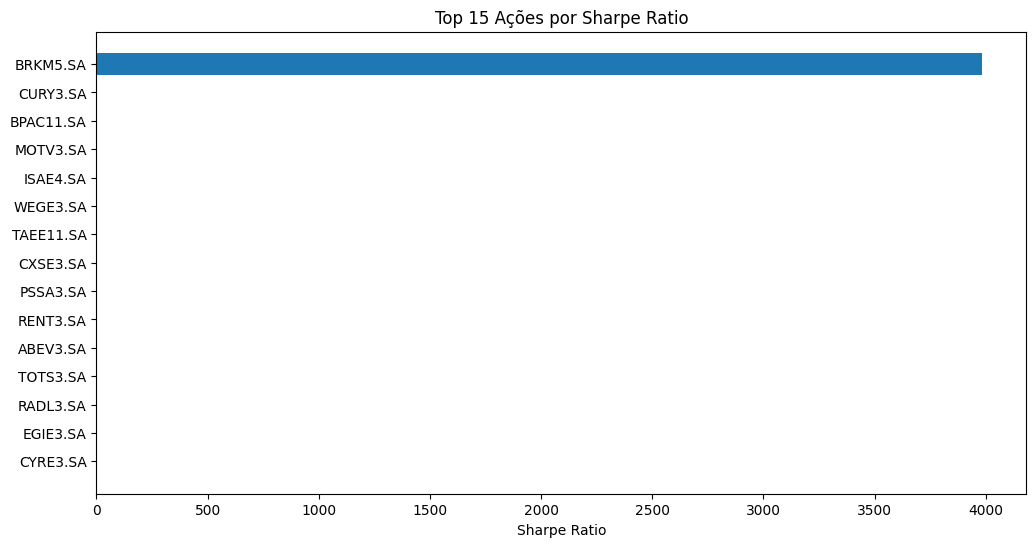

In [15]:
top = df.sort_values("sharpe", ascending=False).head(15)
plt.barh(top["ticker"], top["sharpe"])
plt.gca().invert_yaxis()
plt.xlabel("Sharpe Ratio")
plt.title("Top 15 Ações por Sharpe Ratio")
plt.show()
